In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # 绘图风格
import numpy as np

## k-means 简介

簇：
* 簇中心点是属于该簇的所有数据点坐标的算数平均值
* 一个簇的每个点到该簇中心点的距离，比到其他簇中心点的距离短

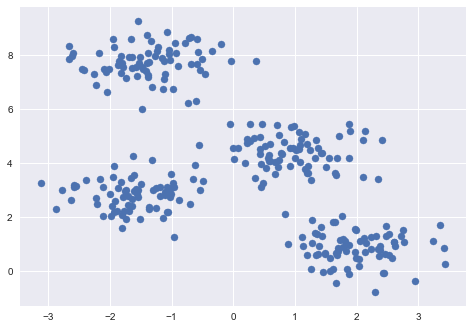

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 300, centers = 4,
                      cluster_std = 0.6, random_state = 0)
plt.scatter(X[:, 0], X[:, 1], s=50)

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

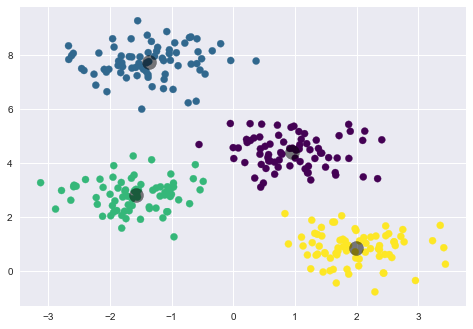

In [4]:
plt.scatter(X[:, 0], X[:, 1], s=50, c=y_kmeans, cmap = 'viridis')

centers = kmeans.cluster_centers_
# 画出 簇 中心点
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

## k-means算法：期望最大化

### E-M：
* 猜测一些簇中心点
* 重复以下步骤直到收敛
    * 期望步骤： 将点分配至离其最近的簇中心点，也就是针对现有的中心点，每个点应该是期望被分配至某个簇
    * 最大化步骤： 将簇中心点设置为所有点坐标的平均值，根据新的期望的簇，算出最优的簇中心点

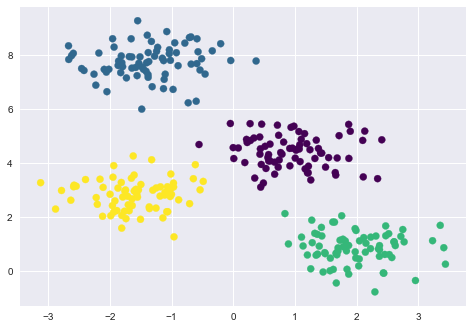

In [5]:
# k-means 算法实现
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### 使用EM时需要考虑到的点
* 可能不会到达全局最优结果， 所以该算法通常会用不同的初始值执行很多遍
* 簇的数量必须实现定好
* 只能确定线性的聚类边界
* 当数据量很大时，k-means 会很慢

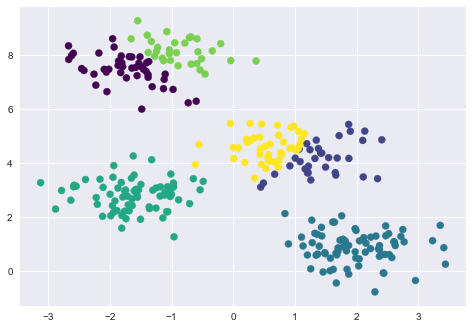

In [6]:
# 无法自己确定簇的数量
labels = KMeans(n_clusters = 6).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

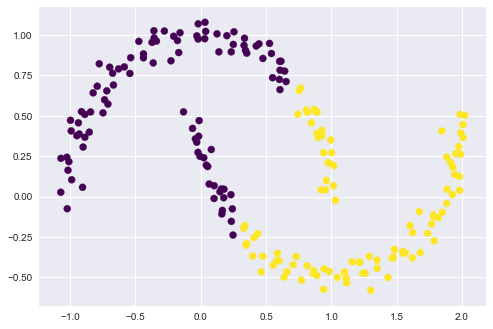

In [7]:
# 只能确定线性的簇类边界

from sklearn.datasets import make_moons
X,y = make_moons(200, noise=.05, random_state = 0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:,0], X[:, 1], c=labels, s=50,
           cmap='viridis')

这时候可以用到核技巧，因为一些核是能够使线性分离的

/Users/vodka/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


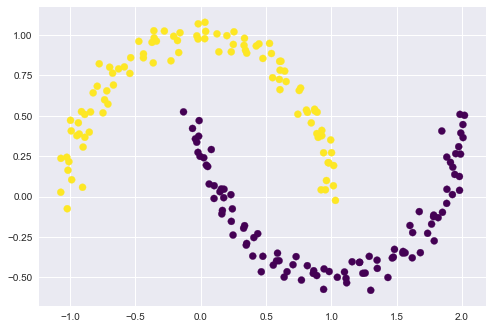

In [8]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters = 2,
                          affinity='nearest_neighbors',
                          assign_labels = 'kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:,0], X[:, 1], c=labels, s=50,
           cmap='viridis')

针对数据量大的情况，可以每次仅使用所有数据中的一个子集来更新簇中心点，理论上也是会收敛的 MiniBatchKMeans

## 案例

### 用kmeans处理手写数字

数据导入

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

数据聚类以后，每个点也是一个 64 维的数据

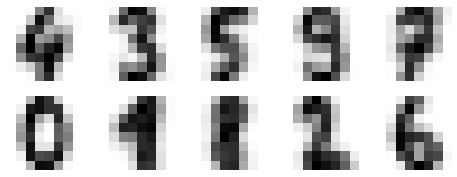

In [11]:
fig,ax = plt.subplots(2, 5, figsize = (8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks = [], yticks = [])
    axi.imshow(center, interpolation = 'nearest', cmap = plt.cm.binary)

1 和 8 有点难找到中心

In [12]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.79354479688369506

混淆矩阵

Text(125.71,0.5,'predicted label')

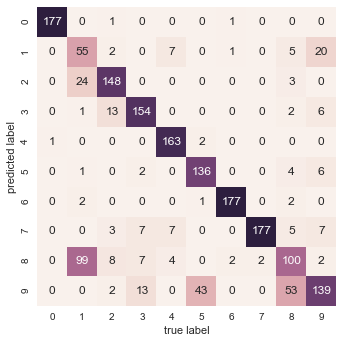

In [14]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

1 和 8 就比较难分

使用 t-SNE 对数据进行流形学习，特别擅长保留簇中的数据点。

In [15]:
from sklearn.manifold import TSNE

# 投影数据
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# 计算类
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# 排列标签
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target, labels)

0.93711741791875347

这就是合理使用无监督学习的力量，无监督学习可以从数据集中抽取难以用手眼直接提取的信息

### 将 k-means 用于色彩压缩

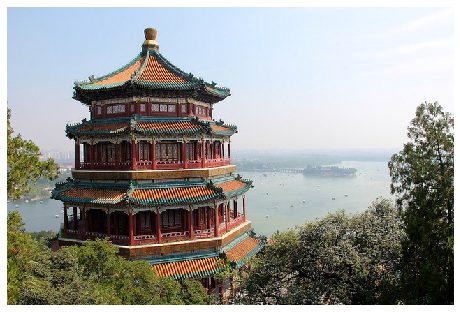

In [16]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg')
ax = plt.axes(xticks = [], yticks = [])
ax.imshow(china)

In [17]:
china.shape

(427, 640, 3)

In [18]:
# 三维颜色空间中的一群数据点
data = china/ 255.0
data = data.reshape(427*640,3)
data.shape

(273280, 3)

In [19]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # 随机选择一个子集
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R,G,B = data[i].T
    
    fig,ax = plt.subplots(1,2,figsize = (16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0,1), ylim=(0,1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0,1), ylim=(0,1))
    
    fig.suptitle(title, size = 20)

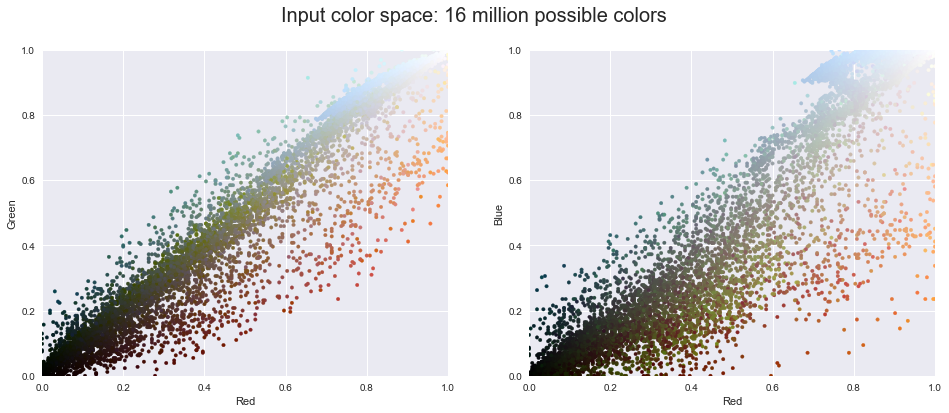

In [20]:
plot_pixels(data, title = 'Input color space: 16 million possible colors')

接下来使用 k-means 聚类，将 1600万种颜色缩减到 16 种颜色， 利用MiniBatchMeans 算法对数据集的子集进行计算

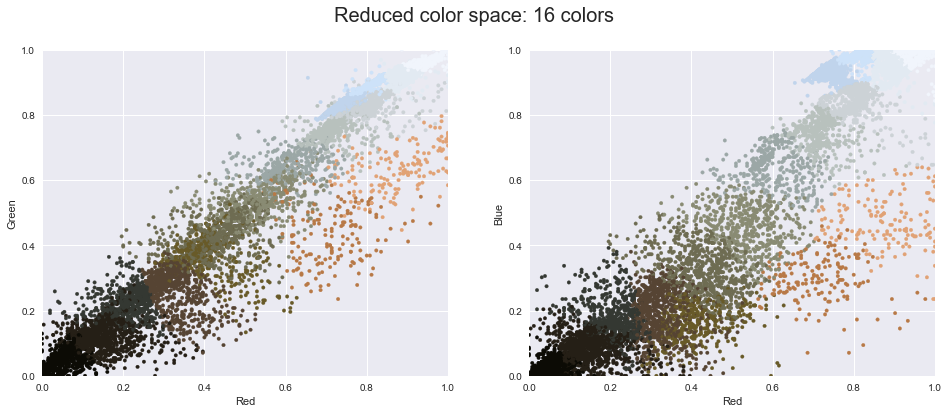

In [21]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors = new_colors,
           title = 'Reduced color space: 16 colors')

重新着色

Text(0.5,1,'16-color Image')

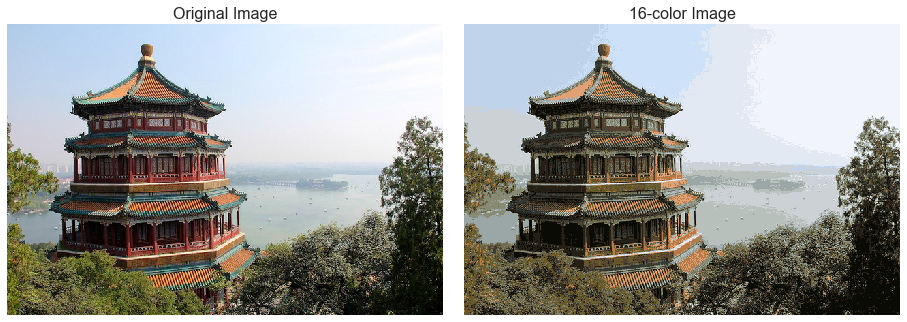

In [22]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize = (16,6),
                      subplot_kw = dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace = 0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

右图实现了将近100万的压缩比